# Lab04 - Joanna Wójcicka

Import of libraries and global parameters

In [128]:
import numpy as np
import matplotlib.pyplot as plt

Functions for the advection diffusion scheme

In [129]:
class shift:
    def __init__(self, add, sub):
        self.add = add
        self.sub = sub
    def __radd__(self, other):
        return slice(other.start + self.add, other.stop + self.add)
    def __rsub__(self, other):
        return slice(other.start - self.sub, other.stop - self.sub)

class Psi_0:
    def __init__(self, *, mu, L, u):
        self.mu = mu  # diffusion coefficient
        self.L = L    # domain length
        self.u = u    # advection speed

    def __call__(self, *, x, t):
        factor = np.exp(-self.mu * (np.pi / self.L)**2 * t)
        phase_shift = np.sin(np.pi * (x - self.u * t) / self.L)
        return factor * phase_shift

In [130]:
def F(a, b, C):
    return a + C * (b - a)

def upwind_safe(psi_analytic, x, dx, dt, nt, u, mu):
    nx = len(x)
    psi = psi_analytic(x=x, t=0)
    output = [psi.copy()]

    # Stability check
    cfl = u * dt / dx
    diff_num = mu * dt / dx**2
    if cfl > 1.0 or diff_num > 0.5:
        raise ValueError(f"Unstable parameters: CFL={cfl:.2f}, Diff={diff_num:.2f}")

    for _ in range(nt):
        psi_new = psi.copy()
        for i in range(1, nx - 1):
            adv = -u * (psi[i] - psi[i - 1]) / dx
            diff = mu * (psi[i + 1] - 2 * psi[i] + psi[i - 1]) / dx**2
            psi_new[i] += dt * (adv + diff)

        # NaN/Inf check
        if not np.all(np.isfinite(psi_new)):
            raise ValueError("Unstable simulation: encountered NaN or Inf in psi")

        psi = psi_new
        output.append(psi.copy())

    return np.array(output)

In [131]:
class Solution:
    def __init__(self, u, mu, L, total_time):
        self.u = u              # Advection speed
        self.mu = mu           # Diffusion coefficient
        self.L = L
        self.total_time = total_time
        self.psi_0 = Psi_0(mu=self.mu, L=self.L, u= self.u)    # Initial Gaussian pulse
        self.dx_values = []     # Store dx values for plotting
        self.errors = []        # Store errors for each test case

    def run(self):
        nx = 64
        x, dx = np.linspace(0, self.L, nx, endpoint=True, retstep=True)
        x = x[:-1] + dx/2
        nt = 500
        t_max = 10
        dt = t_max / nt
        # Numerical solution using upwind
        psi_numerical = upwind_safe(psi_analytic=self.psi_0, x=x, dx=dx, dt=dt, nt=nt, u=self.u, mu=self.mu)
        # Analytical solution (shifted initial condition)
        psi_exact = self.psi_0(x=x, t=t_max)
        
        self.plot_solution(psi_exact, psi_numerical, x)

        return psi_exact, psi_numerical
        
    def plot_solution(self, psi_exact, psi_numerical, x):        
        plt.figure(figsize=(8, 6))
        plt.step(x, psi_exact, label='Analytical Solution')
        plt.step(x, psi_numerical[-1], label='Numerical Solution')
        plt.xlabel('x')
        plt.ylabel('u')
        plt.title('Upwind Scheme')
        plt.legend()
        plt.grid(True)
        plt.show()

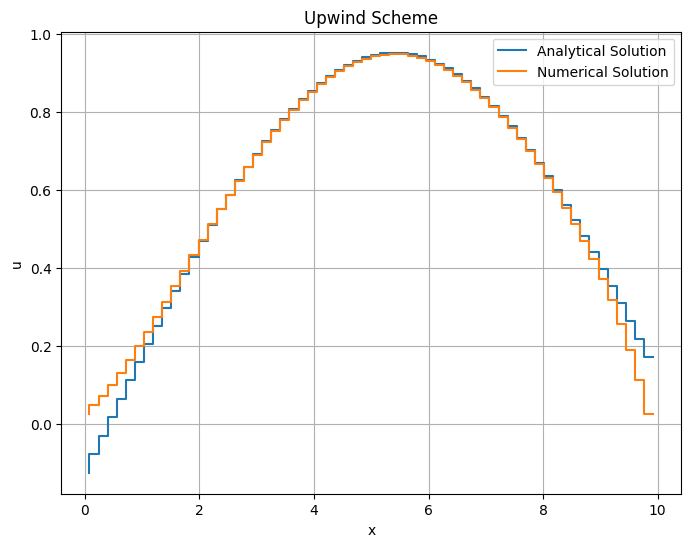

(array([-0.12541772, -0.07822968, -0.03084715,  0.01661207,  0.06402999,
         0.11128872,  0.15827077,  0.20485934,  0.25093859,  0.29639397,
         0.34111246,  0.3849829 ,  0.42789621,  0.4697457 ,  0.51042733,
         0.54983996,  0.5878856 ,  0.62446966,  0.65950119,  0.6928931 ,
         0.72456237,  0.75443026,  0.78242252,  0.80846955,  0.8325066 ,
         0.85447391,  0.87431686,  0.89198612,  0.90743776,  0.92063337,
         0.93154014,  0.94013096,  0.94638446,  0.9502851 ,  0.95182318,
         0.95099488,  0.94780225,  0.94225325,  0.93436165,  0.92414708,
         0.91163493,  0.89685632,  0.87984798,  0.8606522 ,  0.8393167 ,
         0.81589453,  0.79044392,  0.76302814,  0.73371535,  0.70257843,
         0.66969478,  0.63514618,  0.59901849,  0.56140156,  0.52238889,
         0.48207748,  0.44056755,  0.3979623 ,  0.35436765,  0.30989199,
         0.26464588,  0.21874183,  0.17229395]),
 array([[0.02493069, 0.07473009, 0.1243437 , ..., 0.1243437 , 0.07473009,
 

In [132]:
solution = Solution(u=0.05, mu=0.05, L=10, total_time=50)
solution.run()